In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/saless/sample_submission.csv
/kaggle/input/saless/store.csv
/kaggle/input/saless/train.csv
/kaggle/input/saless/test.csv
/kaggle/input/salesd/sample_submission.csv
/kaggle/input/salesd/store.csv
/kaggle/input/salesd/train.csv
/kaggle/input/salesd/test.csv
/kaggle/input/salesf/test_m.csv
/kaggle/input/salesf/train.csv


# Gradient boosting Algorithm********

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import shap
import matplotlib.pyplot as plt

def preprocess_data(df):
    """Preprocess the data: handle missing values, feature engineering, and type conversions."""
    # Handle missing values
    df.dropna(subset=['Date', 'Sales'], inplace=True)

    if 'Customers' in df.columns:
        df['Customers'].fillna(df['Customers'].median(), inplace=True)

    fill_values = {
        'Store': df['Store'].mode()[0],
        'DayOfWeek': df['DayOfWeek'].mode()[0],
        'Open': 1,
        'Promo': 0,
        'StateHoliday': '0',
        'SchoolHoliday': 0
    }
    df.fillna(value=fill_values, inplace=True)

    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

    df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

    return df

def run_sales_prediction(df_train, df_test):
    """Run the sales prediction model, print metrics, and save SHAP plot."""
    features = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
    target = 'Sales'

    X_train = df_train[features]
    y_train = df_train[target]
    X_test = df_test[features]
    y_test = df_test[target]

    # Hyperparameter tuning using Randomized Search
    param_distributions = {
        'n_estimators': np.arange(50, 200, 50),
        'learning_rate': np.linspace(0.01, 0.3, 5),
        'max_depth': np.arange(3, 10, 1),
    }

    gbr = GradientBoostingRegressor(random_state=42)
    random_search = RandomizedSearchCV(estimator=gbr, 
                                       param_distributions=param_distributions,
                                       n_iter=5, 
                                       cv=3, 
                                       verbose=2, 
                                       random_state=42,
                                       n_jobs=-1)

    # Fit the model on the training set
    random_search.fit(X_train, y_train)

    # Get the best model
    best_gbr = random_search.best_estimator_

    # Make predictions on the test data
    df_test['Predicted_Sales'] = best_gbr.predict(X_test)

    # Calculate and print metrics
    rmse = np.sqrt(mean_squared_error(y_test, df_test['Predicted_Sales']))
    mae = mean_absolute_error(y_test, df_test['Predicted_Sales'])
    r2 = r2_score(y_test, df_test['Predicted_Sales'])

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")

    # SHAP analysis
    explainer = shap.TreeExplainer(best_gbr)
    shap_values = explainer.shap_values(X_train)

    # SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, feature_names=features, show=False)
    plt.savefig('shap_summary_plot.png')
    plt.close()
    print("SHAP summary plot saved as 'shap_summary_plot.png'")

    # Load data with specified dtypes
test_file_path = "/kaggle/input/salesf/test_m.csv"
train_file_path = '/kaggle/input/salesf/train.csv'
df_train = pd.read_csv(train_file_path, dtype={'StateHoliday': str})
df_test = pd.read_csv(test_file_path, dtype={'StateHoliday': str})

# Preprocess data
df_train_processed = preprocess_data(df_train)
df_test_processed = preprocess_data(df_test)

# Run the sales prediction
run_sales_prediction(df_train_processed, df_test_processed)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




Fitting 3 folds for each of 5 candidates, totalling 15 fits
RMSE: 965.4319814120271
MAE: 630.9550776220512
R²: 0.891174706880717
[CV] END learning_rate=0.08249999999999999, max_depth=6, n_estimators=50; total time=  58.8s
[CV] END learning_rate=0.22749999999999998, max_depth=3, n_estimators=100; total time= 1.1min
[CV] END learning_rate=0.22749999999999998, max_depth=3, n_estimators=100; total time= 1.1min
[CV] END ..learning_rate=0.155, max_depth=4, n_estimators=50; total time=  43.7s
[CV] END ..learning_rate=0.155, max_depth=4, n_estimators=50; total time=  42.7s
[CV] END ..learning_rate=0.155, max_depth=4, n_estimators=50; total time=  42.2s
[CV] END learning_rate=0.08249999999999999, max_depth=6, n_estimators=50; total time=  58.1s
[CV] END learning_rate=0.22749999999999998, max_depth=3, n_estimators=150; total time= 1.7min
[CV] END .learning_rate=0.155, max_depth=6, n_estimators=150; total time= 3.2min
[CV] END learning_rate=0.08249999999999999, max_depth=6, n_estimators=50; total

# **Random forest regession algorithm:**

 With paramters: 'n_estimators': np.arange(100, 1000, 100)
 'max_depth': np.arange(5, 20, 1)
 'min_samples_split': np.arange(2, 20, 2)
 'min_samples_leaf': np.arange(1, 10, 1)
 'max_features': ['auto', 'sqrt', 'log2']
 'bootstrap': [True, False]



In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import shap
import matplotlib.pyplot as plt

def preprocess_data(df):
    """Preprocess the data: handle missing values, feature engineering, and type conversions."""
    # Handle missing values
    df.dropna(subset=['Date', 'Sales'], inplace=True)

    if 'Customers' in df.columns:
        df['Customers'].fillna(df['Customers'].median(), inplace=True)

    fill_values = {
        'Store': df['Store'].mode()[0],
        'DayOfWeek': df['DayOfWeek'].mode()[0],
        'Open': 1,
        'Promo': 0,
        'StateHoliday': '0',
        'SchoolHoliday': 0
    }
    df.fillna(value=fill_values, inplace=True)

    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

    df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

    return df

def run_sales_prediction(df_train, df_test):
    """Run the sales prediction model using Random Forest, print metrics, and save SHAP plot."""
    features = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
    target = 'Sales'

    X_train = df_train[features]
    y_train = df_train[target]
    X_test = df_test[features]
    y_test = df_test[target]

    # Hyperparameter tuning using Randomized Search for Random Forest
    param_distributions = {
        'n_estimators': np.arange(50, 200, 50),
        'max_depth': np.arange(3, 10, 1),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    rfr = RandomForestRegressor(random_state=42)
    random_search = RandomizedSearchCV(estimator=rfr, 
                                       param_distributions=param_distributions,
                                       n_iter=5, 
                                       cv=3, 
                                       verbose=2, 
                                       random_state=42,
                                       n_jobs=-1)

    # Fit the model on the training set
    random_search.fit(X_train, y_train)

    # Get the best model
    best_rfr = random_search.best_estimator_

    # Make predictions on the test data
    df_test['Predicted_Sales'] = best_rfr.predict(X_test)

    # Calculate and print metrics
    rmse = np.sqrt(mean_squared_error(y_test, df_test['Predicted_Sales']))
    mae = mean_absolute_error(y_test, df_test['Predicted_Sales'])
    r2 = r2_score(y_test, df_test['Predicted_Sales'])

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")

    # SHAP analysis
    explainer = shap.TreeExplainer(best_rfr)
    shap_values = explainer.shap_values(X_train)

    # SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, feature_names=features, show=False)
    plt.savefig('shap_summary_rfplot.png')
    plt.close()
    print("SHAP summary plot saved as 'shap_summary_plot.png'")

# Load data with specified dtypes
train_file_path = '/kaggle/input/salesf/train.csv'
test_file_path = "/kaggle/input/salesf/test_m.csv"
df_train = pd.read_csv(train_file_path, dtype={'StateHoliday': str})
df_test = pd.read_csv(test_file_path, dtype={'StateHoliday': str})

# Preprocess data
df_train_processed = preprocess_data(df_train)
df_test_processed = preprocess_data(df_test)

# Run the sales prediction
run_sales_prediction(df_train_processed, df_test_processed)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




Fitting 3 folds for each of 5 candidates, totalling 15 fits
RMSE: 701.386503078659
MAE: 358.67344692365697
R²: 0.9425617378234142
[CV] END max_depth=9, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=9, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=9, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  20.9s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  20.6s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  20.8s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  59.5s
[CV] END max_depth=9, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estima

In [1]:
!pip install fastapi uvicorn joblib pandas scikit-learn

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




Fitting 3 folds for each of 5 candidates, totalling 15 fits
RMSE: 701.386503078659
MAE: 358.67344692365697
R²: 0.9425617378234142
[CV] END max_depth=9, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.6min
[CV] END max_depth=9, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END max_depth=9, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.6min
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  20.2s
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  20.6s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  20.8s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  57.0s
[CV] END max_depth=9, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimat

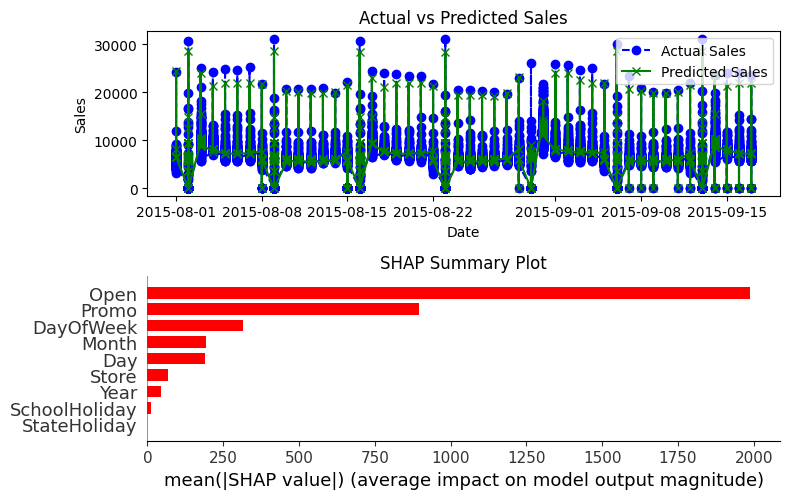

Real vs Predicted Sales and SHAP Summary plot saved as 'real_vs_predicted_shap_summary.png'


In [2]:
# Required Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing Function
def preprocess_data(df):
    """Preprocess the data: handle missing values, feature engineering, and type conversions."""
    # Handle missing values
    df.dropna(subset=['Date', 'Sales'], inplace=True)

    if 'Customers' in df.columns:
        df['Customers'].fillna(df['Customers'].median(), inplace=True)

    fill_values = {
        'Store': df['Store'].mode()[0],
        'DayOfWeek': df['DayOfWeek'].mode()[0],
        'Open': 1,
        'Promo': 0,
        'StateHoliday': '0',
        'SchoolHoliday': 0
    }
    df.fillna(value=fill_values, inplace=True)

    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

    df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

    return df

# Function to Train Model and Generate Predictions
def run_sales_prediction(df_train, df_test):
    """Run the sales prediction model using Random Forest, print metrics, and generate plots."""
    features = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
    target = 'Sales'

    X_train = df_train[features]
    y_train = df_train[target]
    X_test = df_test[features]
    y_test = df_test[target]

    # Hyperparameter tuning using Randomized Search for Random Forest
    param_distributions = {
        'n_estimators': np.arange(50, 200, 50),
        'max_depth': np.arange(3, 10, 1),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    rfr = RandomForestRegressor(random_state=42)
    random_search = RandomizedSearchCV(estimator=rfr, 
                                       param_distributions=param_distributions,
                                       n_iter=5, 
                                       cv=3, 
                                       verbose=2, 
                                       random_state=42,
                                       n_jobs=-1)

    # Fit the model on the training set
    random_search.fit(X_train, y_train)

    # Get the best model
    best_rfr = random_search.best_estimator_

    # Save the model as model.pkl
    import joblib
    joblib.dump(best_rfr, 'model.pkl')

    # Make predictions on the test data
    df_test['Predicted_Sales'] = best_rfr.predict(X_test)

    # Calculate and print metrics
    rmse = np.sqrt(mean_squared_error(y_test, df_test['Predicted_Sales']))
    mae = mean_absolute_error(y_test, df_test['Predicted_Sales'])
    r2 = r2_score(y_test, df_test['Predicted_Sales'])

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")

    # SHAP analysis
    explainer = shap.TreeExplainer(best_rfr)
    shap_values = explainer.shap_values(X_train)

    # Plotting Real vs Predicted Sales and SHAP Summary in a subplot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    # Subplot 1: Real vs Predicted Sales
    axes[0].plot(df_test['Date'], y_test, label="Actual Sales", color='blue', marker='o', linestyle='dashed')
    axes[0].plot(df_test['Date'], df_test['Predicted_Sales'], label="Predicted Sales", color='green', marker='x')
    axes[0].set_title('Actual vs Predicted Sales')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Sales')
    axes[0].legend(loc='upper right')

    # Subplot 2: SHAP Summary Plot
    shap.summary_plot(shap_values, X_train, feature_names=features, show=False, plot_type="bar", color="red")
    plt.subplot(2, 1, 2)
    plt.title("SHAP Summary Plot")

    # Save combined figure as a PNG
    plt.tight_layout()
    plt.savefig('real_vs_predicted_shap_summary.png')
    plt.show()
    print("Real vs Predicted Sales and SHAP Summary plot saved as 'real_vs_predicted_shap_summary.png'")

# Load data with specified dtypes
train_file_path = '/kaggle/input/salesf/train.csv'
test_file_path = "/kaggle/input/salesf/test_m.csv"
df_train = pd.read_csv(train_file_path, dtype={'StateHoliday': str})
df_test = pd.read_csv(test_file_path, dtype={'StateHoliday': str})

# Preprocess data
df_train_processed = preprocess_data(df_train)
df_test_processed = preprocess_data(df_test)

# Run the sales prediction
run_sales_prediction(df_train_processed, df_test_processed)

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

# Initialize FastAPI app
app = FastAPI()

# Load the trained machine learning model
model = joblib.load("/kaggle/working/model.pkl")

# Define the input data structure using Pydantic
class InputData(BaseModel):
    feature1: float
    feature2: float
    # Add all other features here

# Health check route
@app.get("/")
def read_root():
    return {"message": "Model is ready to serve!"}

# Prediction route
@app.post("/predict/")
def predict(data: InputData):
    # Convert input data into a numpy array or the format required by your model
    input_array = np.array([[data.feature1, data.feature2]])  # Add other features accordingly
    
    # Preprocess the input data if needed
    
    # Make predictions
    prediction = model.predict(input_array)
    
    # Format the prediction for output
    return {"prediction": prediction.tolist()}